https://medium.com/@galen.ballew/opencv-lanedetection-419361364fc0

* Convert Image to grayscale
* filter the image with only white color present(no need for yellow since it does not need.)
* Perform canny edge to find all the edges
* Perform region of interest
* Perform hough line transform
* Put detected lines back on the original images

https://docs.opencv.org/3.1.0/d4/d73/tutorial_py_contours_begin.html
* find contours for cv2

## ToDo
- [x] Add ROI to improve accuracy
- [ ] Modify slope threshold to find better fit

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
%matplotlib inline

In [37]:
def open_img(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

In [38]:
def open_img_color(img):
    image = cv2.imread(img)
    return image

In [39]:
def show_image_color(img):
    temp = img[:,:,-1]
    img[:,:,-1] = img[:,:,0]
    img[:,:,0] = temp
    plt.imshow(img)
    plt.show()

In [40]:
def show_image_gray(img):
    plt.imshow(img,  cmap='gray')
    plt.show()

In [41]:
def do_erode(img,iteration):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iteration)
    return erosion

In [42]:
def do_dilate(img,iteration):
    #https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iteration)
    return dilation

In [43]:
def filtered_white(img,low_white,high_white):
    mask_white = cv2.inRange(img, low_white, high_white)
    img = cv2.bitwise_and(img, mask_white)
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    #show_image_gray(gauss_gray)
    return gauss_gray

In [44]:
def ROI(img):
    h,w = img.shape[0],img.shape[1]
    #print(h)
    #print(w)
    triangle = np.array([[(49,h),(429,h),(250,100)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask,triangle,255)
    #show_image_gray(mask)
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

In [45]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [52]:
def find_x_coordinate(img,param):
    #print(param)
    slope,intercept = param
    
    y1 = img.shape[0]
    y2 = int(y1*(2/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1,y1,x2,y2])
def find_and_draw_lines(original_img,lines):
    combo_img = original_img.copy()
    left_line = []
    right_line = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        x = [x1,x2]
        y = [y1,y2]
       # print("x {}".format(x))
        #print("y {}".format(y))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #print(intercept)
        param = [slope, intercept]
        #param = np.polyfit((x1,x2),(y1,y2),1)
        #slope = param[0]
        if math.isnan(slope) == False and math.isnan(intercept) == False:
            if slope < -0.8:
                left_line.append(param)
            elif slope > 0.8:
                right_line.append(param)
    
    l_line = list()
    r_line = list()
    line_img = np.zeros_like(original_img)
    if len(left_line) != 0:    
        left_line_avg = np.mean(left_line,axis = 0)
        l_line = find_x_coordinate(img,left_line_avg)
        cv2.line(line_img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
    if len(right_line) != 0:
        right_line_avg = np.mean(right_line,axis = 0)
        r_line = find_x_coordinate(img,right_line_avg)
        cv2.line(line_img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)

    combo_img = cv2.addWeighted(original_img,1,line_img,1,1)
    return combo_img
    #print(left_line_avg)
    

In [53]:
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)
def find_draw_best_lines(original_img,lines):
    combo_img = original_img.copy()
    l_line = []
    r_line = []
    for line in lines:
        #print(line)
        det_slope = 0.8
        x1,y1,x2,y2 = line.reshape(4)
        slope = get_slope(x1,y1,x2,y2)
        if slope < -det_slope:
            l_line.append(x1)
            l_line.append(y1)
            l_line.append(x2)
            l_line.append(y2)
        elif slope > det_slope:
            r_line.append(x1)
            r_line.append(y1)
            r_line.append(x2)
            r_line.append(y2)

        if len(l_line) != 0 and len(r_line) != 0:
            line_img = np.zeros_like(original_img)
            cv2.line(line_img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
            cv2.line(line_img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)
            combo_img = cv2.addWeighted(original_img,1,line_img,1,1)
            return combo_img
    return combo_img

In [59]:

def hough_lines(original_img, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    if len(lines) == 0:
        return
    combo_img = find_draw_best_lines(original_img.copy(),lines)
    #combo_img = find_and_draw_lines(original_img.copy(),lines)
    return combo_img

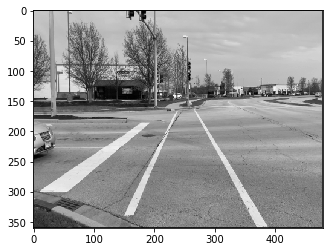

1. filtered image with white present.


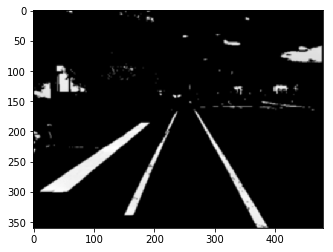

2. Canny Edge using openCV


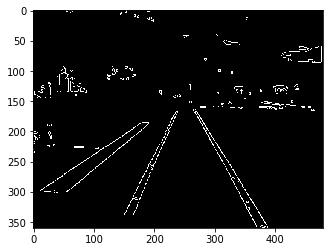

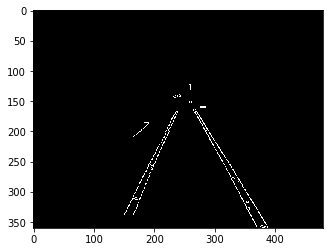

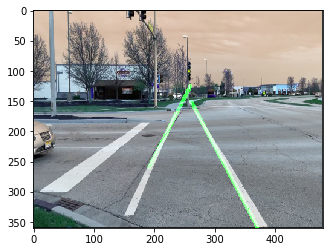

In [60]:
###main
#https://abhishek4273.com/2014/03/15/fast-roadpath-detection-using-opencv/
### 1038.png
img_color = open_img_color('1038.png')
img = open_img('1038.png')
img = cv2.resize(img,(480,360))
img_color = cv2.resize(img_color,(480,360))
img_2 = open_img('stair_crosswalk_1.jpg')
img_3 = open_img('stair_crosswalk_2.jpg')
show_image_gray(img)
#show_image_gray(img_2)
#show_image_gray(img_3)
#img = do_erode(img,7)
#img = do_dilate(img,7)
#do filter 
print("1. filtered image with white present.")
img = filtered_white(img,200,255)
show_image_gray(img)
#img_2 = filtered_white(img_2,200,255)
#img_3 = filtered_white(img_3,200,255)

print("2. Canny Edge using openCV")
#canny_img = auto_canny(img)
canny_img = cv2.Canny(img,100,150)
#canny_img_2 = cv2.Canny(img_2,250,400)
#canny_img_3 = cv2.Canny(img_3,250,250)
#hough_transform(img,canny_img)
show_image_gray(canny_img)
#show_image_gray(canny_img_2)
#show_image_gray(canny_img_3)
img_roi = ROI(canny_img)
show_image_gray(img_roi)
rho = 4
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 30
min_line_len = 50
max_line_gap = 50
#my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

line_image = hough_lines(img_color,img_roi, rho, theta, threshold, min_line_len, max_line_gap)
show_image_gray(line_image)

In [61]:
print('cv2 finished')

cv2 finished


In [63]:

cap = cv2.VideoCapture('../dataset/16.m4v')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('16_output_most_vote_0.8_70.avi',fourcc, 30.0, (480,360))
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(gray,(480,360))
    color = cv2.resize(frame,(480,360))
    img = filtered_white(img,200,255)
    
    canny_img = cv2.Canny(img,100,150)
    img_roi = ROI(canny_img)
    rho = 4
    theta = np.pi/180
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    threshold = 40
    min_line_len = 50
    max_line_gap = 100
    #my hough values started closer to the values in the quiz, but got bumped up considerably for the challenge video

    combo_img = hough_lines(color,img_roi, rho, theta, threshold, min_line_len, max_line_gap)
    out.write(combo_img)
    #cv2.imshow('frame',color)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
out.release()
cap.release()
cv2.destroyAllWindows()
print("output finished")

/Users/xiaotengyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in int_scalars
  


output finished
